TP1 - Recalage d'images
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt


Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images():
    n = 21
    sigma = 0.3
    [X, Y] = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n), indexing="xy")
    Z = np.sqrt(X * X + Y * Y)
    im1 = np.zeros((n, n))
    im1[Z <= 0.7] = 1.0
    im1[Z <= 0.3] = 0.5
    im1[Z <= 0.1] = 0.7
    im2 = np.zeros((n, n))
    Z = np.sqrt((X - 0.3) ** 2 + (Y + 0.2) ** 2)
    im2[Z <= 0.7] = 1
    im2[Z <= 0.3] = 0.5
    im2[Z <= 0.1] = 0.7
    G = np.fft.fftshift(np.exp(-(X ** 2 + Y ** 2) / sigma ** 2))
    f = np.real(np.fft.ifft2(np.fft.fft2(G) * np.fft.fft2(im1)))
    g = np.real(np.fft.ifft2(np.fft.fft2(G) * np.fft.fft2(im2)))
    f = f / np.max(f)
    g = g / np.max(g)
    return f, g


In [3]:
f, g = get_images()


# 1. Formalisation du problème

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

On effectue un développement de Taylor de $h$:
$$
E(x + h) = E(u) + \langle \nabla E(u), h \rangle + o(\| h \|)
$$

En plus:
$$
\begin{aligned}
E(x + h) &= \frac{1}{2} \int_ \Omega (f(x + u(x) + h(x)) - g(x))^2 \mathop{dx} \\
&= \frac{1}{2} \int_ \Omega (f(x + u(x)) + \langle \nabla f(x + u(x)), h \rangle + o(\| h \|) - g(x))^2 \mathop{dx} \\
&= \frac{1}{2} \int_ \Omega (f(x + u(x)) + \langle \nabla f(x + u(x)), h \rangle - g(x))^2 + o(\| h \|) \mathop{dx} \\
\end{aligned}
$$

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [4]:
def interpol(f, ux, uy):
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx, ny = f.shape
    ip = interpolate.RectBivariateSpline(np.arange(nx), np.arange(ny), f)
    [X, Y] = np.meshgrid(np.arange(nx), np.arange(ny), indexing="ij")
    X = X + ux
    Y = Y + uy
    return np.reshape(ip.ev(X.ravel(), Y.ravel()), (nx, ny))


2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

D'abord,
$$
(\partial_{y} f)_{i,j} =
\begin{cases}
f_{i,j + 1} - f_{i,j} \text { si } j < n \\
0
\end{cases}
$$
En suite,
$$
\begin{aligned}
\langle \partial_{x} u, v \rangle &= \sum_{i = 1}^{n} \sum_{j = 1}^{n} (\partial_{x} f)_{i,j} v_{i, j}\\
&= \sum_{i = 1}^{n - 1} \sum_{j = 1}^{n} (u_{i + 1, j} - u_{i, j})v_{i, j} \\
&= \sum_{i = 1}^{n - 1} \sum_{j = 1}^{n} u_{i + 1, j} v_{i, j} - \sum_{i = 1}^{n - 1} \sum_{j = 1}^{n} u_{i, j} v_{i, j} \\
&= \sum_{i = 2}^{n} \sum_{j = 1}^{n} u_{i, j} v_{i - 1, j} - \sum_{i = 1}^{n - 1} \sum_{j = 1}^{n} u_{i, j} v_{i, j} \\
&= \sum_{i = 2}^{n - 1} \sum_{j = 1}^{n} u_{i, j} (v_{i - 1, j} - v_{i, j}) + \sum_{j = 1}^{n} u_{n, j} v_{n - 1, j} - \sum_{j = 1}^{n} u_{1, j} v_{1, j} \\
&= \langle u, \partial_{x}^{\top} v \rangle \\
\end{aligned}
$$
Donc, par identification:
$$
(\partial_{x} f)_{i,j} =
\begin{cases}
f_{i - 1,j} - f_{i,j} \text { si } 2 \le i \le n - 1 \\
f_{n - 1, j} \text { si } i = n \\
-f_{1, j} \text { si } i = 1 \\
\end{cases}
$$
De la même manière:
$$
(\partial_{y} f)_{i,j} =
\begin{cases}
f_{i,j - 1} - f_{i,j} \text { si } 2 \le j \le n - 1 \\
f_{i, n - 1} \text { si } j = n \\
-f_{i, 1} \text { si } j = 1 \\
\end{cases}
$$

In [5]:
def dx(im):
    d = np.zeros(im.shape)
    d[:-1, :] = im[1:, :] - im[:-1, :]
    return d


def dy(im):
    d = np.zeros(im.shape)
    d[:, :-1] = im[:, 1:] - im[:, :-1]
    return d


def dyT(im):
    d = np.zeros(im.shape)
    d[:, 0] = -im[:, 0]
    d[:, -1] = im[:, -2]
    d[:, 1:-1] = im[:, :-2] - im[:, 1:-1]
    return d


def dxT(im):
    d = np.zeros(im.shape)
    d[0, :] = -im[0, :]
    d[-1, :] = im[-2, :]
    d[1:-1, :] = im[:-2, :] - im[1:-1, :]
    return d


Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

D'abord:
$$
\begin{aligned}
R_{1}(u) &= \mu \sum_{i}(\partial_{x} u_y + \partial_{y} u_x)^2(i) \\
&= \mu \| \partial_{x} u_y + \partial_{y} u_x \|^2 \\
&= \left\| \sqrt{\mu} \begin{pmatrix} \partial_{y} & \partial_{x} \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} \right\|^2 \\
&= \| A_1 u \|^2 \\
\implies A_1 &= \sqrt{\mu} \begin{pmatrix} \partial_{y} & \partial_{x} \end{pmatrix} \\
\end{aligned}
$$
De la même manière:
$$
A_2 = \sqrt{\lambda + \mu} \begin{pmatrix} \partial_{x} & \partial_{y} \end{pmatrix} \\
$$
Finallement,
$$
\begin{aligned}
R(u) &= \frac{1}{2} R_1(u) + \frac{1}{2} R_2(u) \\
&= \frac{1}{2} \langle A_1 u , A_1 u \rangle + \frac{1}{2} \langle A_2 u , A_2 u \rangle \\
&= \frac{1}{2} \langle A_{1}^{\top} A_1 u , u \rangle + \frac{1}{2} \langle A_{2}^{\top} A_2 u , u \rangle \\
&= \frac{1}{2} \langle A \begin{pmatrix} u_x \\ u_y \end{pmatrix} , \begin{pmatrix} u_x \\ u_y \end{pmatrix} \rangle_{V^2} \\
\text { avec } A &= A_{1}^{\top} A_1 + A_{2}^{\top} A_2 \\
\end{aligned}
$$

Q4. Donner l'expression du gradient de $R$.

Selon la question précédente:
$$
\begin{aligned}
\nabla R(u) &= Au \\
&= A_{1}^{\top} A_1 u + A_{2}^{\top} A_2 u \\
&= \mu \begin{pmatrix} \partial_{y}^{\top} \\ \partial_{x}^{\top} \end{pmatrix} \begin{pmatrix} \partial_{y} & \partial_{x} \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} + (\lambda + \mu) \begin{pmatrix} \partial_{x}^{\top} \\ \partial_{y}^{\top} \end{pmatrix} \begin{pmatrix} \partial_{x} & \partial_{y} \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} \\
&= \mu \begin{pmatrix} \partial_{y}^{\top} \partial_{y} & \partial_{y}^{\top} \partial_{x} \\ \partial_{x}^{\top} \partial_{y} & \partial_{x}^{\top} \partial_{x} \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} + (\lambda + \mu) \begin{pmatrix} \partial_{x}^{\top} \partial_{x} & \partial_{x}^{\top} \partial_{y} \\ \partial_{y}^{\top} \partial_{x} & \partial_{y}^{\top} \partial_{y} \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} \\
&= \mu \begin{pmatrix} \partial_{y}^{\top} \partial_{y} u_x + \partial_{y}^{\top} \partial_{x} u_y \\ \partial_{x}^{\top} \partial_{y} u_x + \partial_{x}^{\top} \partial_{x} u_y \end{pmatrix} + (\lambda + \mu) \begin{pmatrix} \partial_{x}^{\top} \partial_{x} u_x + \partial_{x}^{\top} \partial_{y} u_y \\ \partial_{y}^{\top} \partial_{x} u_x + \partial_{y}^{\top} \partial_{y} u_y \end{pmatrix} \\
\end{aligned}
$$

2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [6]:
def objective_function(f, g, ux, uy, lamb, mu):
    fu = interpol(f, ux, uy)
    Eu = 1 / 2 * np.sum((fu - g) ** 2)
    Ru = (
        mu * np.sum((dx(uy) + dy(ux)) ** 2)
        + (lamb + mu) * np.sum((dx(ux) + dy(uy)) ** 2)
    ) / 2
    obj = Eu + Ru
    return obj, fu


# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [7]:
def linesearch(ux, uy, step, descentx, descenty, obj_old, f, g, lamb, mu):
    step = 2 * step
    tmpx = ux - step * descentx
    tmpy = uy - step * descenty
    obj, fu = objective_function(f, g, tmpx, tmpy, lamb, mu)
    while obj > obj_old and step > 1.0e-8:
        step = 0.5 * step
        tmpx = ux - step * descentx
        tmpy = uy - step * descenty
        obj, fu = objective_function(f, g, tmpx, tmpy, lamb, mu)
    return tmpx, tmpy, step


In [8]:
def RecalageDG(f, g, lamb, mu, nitermax, stepini, shouldlog=True):
    ux = np.zeros(f.shape)
    uy = np.zeros(f.shape)
    CF = []
    step_list = []
    niter = 0
    step = stepini
    while niter < nitermax and step > 1.0e-8:
        niter += 1
        obj, fu = objective_function(f, g, ux, uy, lamb, mu)
        CF.append(obj)
        # Gradient of E at point u
        gradfx = interpol(dx(f), ux, uy)
        gradfy = interpol(dy(f), ux, uy)
        gradEcommon = fu - g
        gradEx = gradEcommon * gradfx
        gradEy = gradEcommon * gradfy

        # Gradient of R at point u
        gradRx = mu * (dyT(dy(ux)) + dyT(dx(uy))) + (mu + lamb) * (
            dxT(dx(ux)) + dxT(dy(uy))
        )
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (mu + lamb) * (
            dyT(dx(ux)) + dyT(dy(uy))
        )

        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy

        ux, uy, step = linesearch(ux, uy, step, gradx, grady, obj, f, g, lamb, mu)
        step_list.append(step)
        if niter % 3 == 0 and shouldlog:
            print("iteration :", niter, " cost function :", obj, "step :", step)
    return ux, uy, np.array(CF), np.array(step_list)


Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [9]:
lamb = 10
mu = 20
nitermax = 500

step0 = 0.01


iteration : 3  cost function : 19.081254925606988 step : 0.08
iteration : 6  cost function : 19.042743727061186 step : 0.02
iteration : 9  cost function : 19.031367910404178 step : 0.01
iteration : 12  cost function : 19.024123838887306 step : 0.01
iteration : 15  cost function : 19.018062108808987 step : 0.01
iteration : 18  cost function : 19.012534592575683 step : 0.005
iteration : 21  cost function : 19.008553844119763 step : 0.005
iteration : 24  cost function : 19.00309484901697 step : 0.005
iteration : 27  cost function : 18.998331455402845 step : 0.005
iteration : 30  cost function : 18.99381720889842 step : 0.005
iteration : 33  cost function : 18.98942613969346 step : 0.005
iteration : 36  cost function : 18.985108875828224 step : 0.01
iteration : 39  cost function : 18.981933800562796 step : 0.005
iteration : 42  cost function : 18.977325922450245 step : 0.005
iteration : 45  cost function : 18.97284382670822 step : 0.005
iteration : 48  cost function : 18.96844916660078 ste

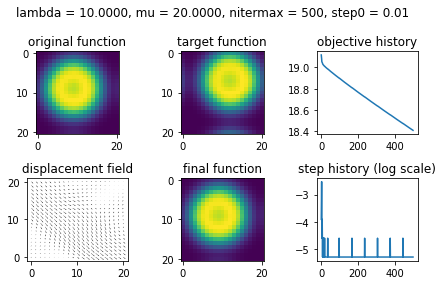

In [10]:
def plot_result(f, g, ux, uy, CF, step, lamb, mu, nitermax, step0):
    fig, ax = plt.subplots(2, 3)
    ax[0, 0].imshow(f)
    ax[0, 0].set_title("original function")
    ax[0, 1].imshow(g)
    ax[0, 1].set_title("target function")
    ax[1, 0].quiver(ux, uy)
    ax[1, 0].set_title("displacement field")
    ax[1, 1].imshow(interpol(f, ux, uy))
    ax[1, 1].set_title("final function")
    ax[0, 2].plot(CF)
    ax[0, 2].set_title("objective history")
    ax[1, 2].plot(np.log(step))
    ax[1, 2].set_title("step history (log scale)")
    fig.suptitle(f"lambda = {lamb:.4f}, mu = {mu:.4f}, nitermax = {nitermax}, step0 = {step0}")

    plt.tight_layout()
    plt.show()


def compute_and_plot(f, g, lamb, mu, nitermax, step0, shouldlog=True):
    ux, uy, CF, step = RecalageDG(f, g, lamb, mu, nitermax, step0, shouldlog)
    plot_result(f, g, ux, uy, CF, step, lamb, mu, nitermax, step0)
    return ux, uy, CF, step


ux, uy, CF, step = compute_and_plot(f, g, lamb, mu, nitermax, step0)


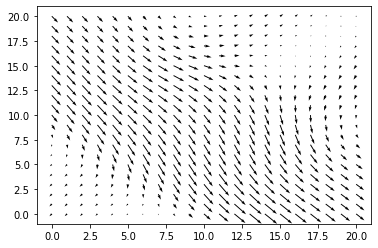

In [11]:
plt.quiver(ux, uy)
plt.show()


In [12]:
def plot_contour_lambda_mu(f, g, lambs, mus, nitermax=500, step0=0.01, onlyCF=True):
    niters = np.empty(np.shape(lambs) + np.shape(mus))
    CFs = np.empty_like(niters)
    Es = np.empty_like(niters)
    total_count = np.size(Es)
    row_count = np.size(mus)
    for i, lamb in enumerate(lambs):
        for j, mu in enumerate(mus):
            print(
                f"{int(100 * (i * row_count + j + 1) / total_count)}%",
                end="\r",
            )
            ux, uy, CF, step = RecalageDG(f, g, lamb, mu, nitermax, step0, False)
            CFs[i, j] = CF[-1]
            if onlyCF:
                continue
            fu = interpol(f, ux, uy)
            niters[i, j] = step.size
            Es[i, j] = 1 / 2 * np.sum((fu - g) ** 2)

    graphs = (
        [
            (niters, "Number of iterations", "Blues", "%d"),
            (CFs, "Cost function (E + R)", "Greens", "%.2f"),
            (Es, "E", "Oranges", "%.2f"),
        ]
        if not onlyCF
        else [(CFs, "Cost function (E + R)", "Greens", "%.2f")]
    )

    for i, (graph, title, color, fmt) in enumerate(graphs):
        contour = plt.contourf(mus, lambs, graph, cmap=plt.get_cmap(color))
        plt.colorbar(contour, format=fmt)
        plt.xlabel("mu")
        plt.ylabel("lambda")
        plt.title(f"{title} in function of lambda and mu")
        plt.show()


`plot_contour_lambda_mu` tracera la valeur de la fonction de coût en fonction de $\lambda$ et $\mu$.


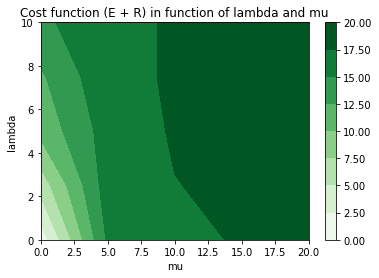

In [13]:
plot_contour_lambda_mu(f, g, np.linspace(0, 10, 5), np.linspace(0, 20, 5))


Puisque on essaie de minimiser $(P)$, on s'intérese à la valeur de $\lambda$ et $\mu$ où $\text{ Cost function } = E(u) + R(u)$ est petite. On donc refait avec $\lambda \in [0; 2] \text { et } \mu \in [0; 1]$.

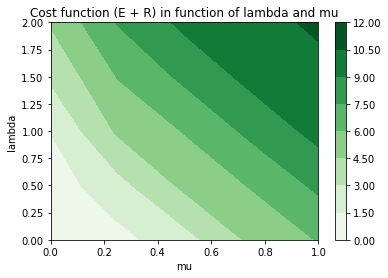

In [14]:
plot_contour_lambda_mu(f, g, np.linspace(0, 2, 5), np.linspace(0, 1, 5))


Avec $\lambda \in [0; 1] \text { et } \mu \in [0; 0,5]$

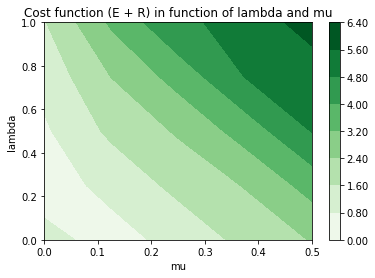

In [15]:
plot_contour_lambda_mu(f, g, np.linspace(0, 1, 5), np.linspace(0, 0.5, 5))


Avec $\lambda \in [0; 0,5] \text { et } \mu \in [0; 0,2]$

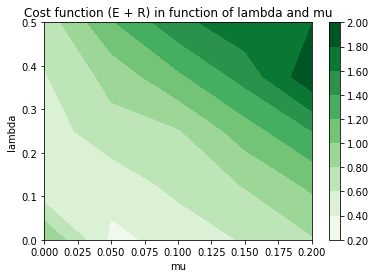

In [16]:
plot_contour_lambda_mu(f, g, np.linspace(0, 0.5, 5), np.linspace(0, 0.2, 5))


Avec $\lambda \in [0; 0,05] \text { et } \mu \in [0,05; 0,075]$

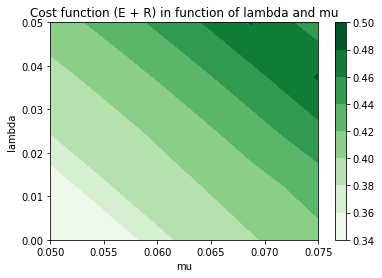

In [17]:
plot_contour_lambda_mu(f, g, np.linspace(0, 0.05, 5), np.linspace(0.05, 0.075, 5))


Avec $\lambda \in [0; 0,01] \text { et } \mu \in [0,05; 0,055]$. On peut choisir par example, $\lambda = 0,008 \text { et } \mu = 0,054$. Cela garantira que $ \min E(u)+R(u) < 0,35$. De plus, on voit que $\lambda = 0 \text { et } \mu = 0$ n'est pas une condition nécessaire pour minimiser $E(u)+R(u)$.

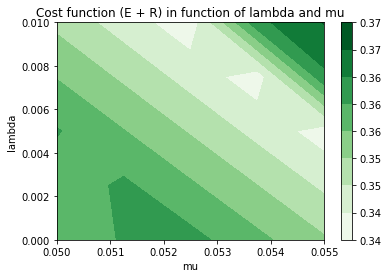

In [18]:
plot_contour_lambda_mu(f, g, np.linspace(0, 0.01, 5), np.linspace(0.05, 0.055, 5))


iteration : 3  cost function : 19.066292036338098 step : 0.08
iteration : 6  cost function : 18.601571015137598 step : 0.64
iteration : 9  cost function : 15.47055092974357 step : 5.12
iteration : 12  cost function : 6.756536555036603 step : 20.48
iteration : 15  cost function : 5.0673872523810655 step : 2.56
iteration : 18  cost function : 4.869164621851196 step : 1.28
iteration : 21  cost function : 4.194890959134304 step : 2.56
iteration : 24  cost function : 3.846061305921591 step : 2.56
iteration : 27  cost function : 3.640815413869529 step : 1.28
iteration : 30  cost function : 3.2601876340543283 step : 2.56
iteration : 33  cost function : 2.995393618860212 step : 5.12
iteration : 36  cost function : 2.75702330201725 step : 2.56
iteration : 39  cost function : 2.6416506975347556 step : 1.28
iteration : 42  cost function : 2.4085926749514237 step : 1.28
iteration : 45  cost function : 2.2199983953175573 step : 2.56
iteration : 48  cost function : 2.076488811709445 step : 5.12
iter

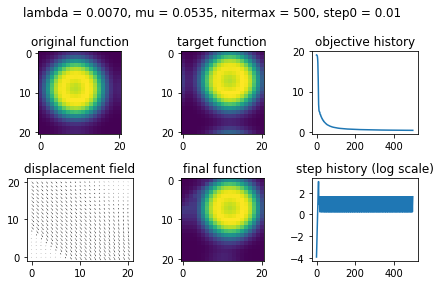

In [19]:
lamb = 0.007
mu = 0.0535

nitermax = 500
step0 = 0.01
ux, uy, CF, step = compute_and_plot(f, g, lamb, mu, nitermax, step0)


On remarque que la "final function" est très proche de la "target function".

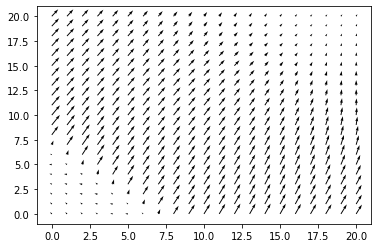

In [20]:
plt.quiver(ux, -uy)
plt.show()


# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad { avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

On a:
$$
J_\Psi(u) = \begin{pmatrix} \nabla^{\top} \Psi_1(u) \\ \nabla^{\top} \Psi_2(u) \\ \nabla^{\top} \Psi_3(u) \end{pmatrix}
$$
d'où:
$$
\begin{cases}
\nabla^{\top} \Psi_1(u) &= \nabla^{\top} f \circ (Id + u) = \begin{pmatrix} df_x \circ (Id + u) & df_y \circ (Id + u) \end{pmatrix} \\
\nabla^{\top} \Psi_2(u) &= \sqrt{\mu} \begin{pmatrix} \partial_{y} & \partial_{x} \end{pmatrix} \\
\nabla^{\top} \Psi_3(u) &= \sqrt{\mu + \lambda} \begin{pmatrix} \partial_{x} & \partial_{y} \end{pmatrix}
\end{cases}
$$
Donc:
$$
J_\Psi(u) = \begin{pmatrix} df_x \circ (Id + u) & df_y \circ (Id + u) \\
\sqrt{\mu} \partial_{y} & \sqrt{\mu} \partial_{x} \\
\sqrt{\mu + \lambda} \partial_{x} & \sqrt{\mu + \lambda} \partial_{y} \end{pmatrix}
$$


Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [21]:
def JTPsi(phi, df, lamb, mu):
    sqrt_mu = np.sqrt(mu)
    sqrt_lamb_mu = np.sqrt(mu + lamb)
    ux = df[0] * phi[0] + sqrt_mu * dyT(phi[1]) + sqrt_lamb_mu * dxT(phi[2])
    uy = df[1] * phi[0] + sqrt_mu * dxT(phi[1]) + sqrt_lamb_mu * dyT(phi[2])
    return [ux, uy]


def JPsi(vx, vy, df, lamb, mu):
    sqrt_mu = np.sqrt(mu)
    sqrt_lamb_mu = np.sqrt(mu + lamb)
    JPsi0 = df[0] * vx + df[0] * vy
    JPsi1 = sqrt_mu * (dy(vx) + dx(vy))
    JPsi2 = sqrt_lamb_mu * (dx(vx) + dy(vy))
    return [JPsi0, JPsi1, JPsi2]


def JTJ(vx, vy, df, lamb, mu, epsilon):
    phi = JPsi(vx, vy, df, lamb, mu)
    usx, uys = JTPsi(phi, df, lamb, mu)
    uxs = usx + epsilon * vx
    uys = uys + epsilon * vy
    return uxs, uys


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [22]:
def CGSolve(u0x, u0y, lamb, mu, b, epsilon, df):
    nitmax = 100
    ux = u0x
    uy = u0y
    # point de départ de l'algorithme
    # Computes JTJu
    Ax, Ay = JTJ(ux, uy, df, lamb, mu, epsilon)
    rx = b[0] - Ax
    ry = b[1] - Ay
    px = rx
    py = ry
    rsold = np.linalg.norm(rx) ** 2 + np.linalg.norm(ry) ** 2
    for i in range(nitmax):
        Apx, Apy = JTJ(px, py, df, lamb, mu, epsilon)
        alpha = rsold / (np.vdot(rx[:], Apx[:]) + np.vdot(ry[:], Apy[:]))
        ux = ux + alpha * px
        uy = uy + alpha * py
        rx = rx - alpha * Apx
        ry = ry - alpha * Apy
        rsnew = np.linalg.norm(rx) ** 2 + np.linalg.norm(ry) ** 2
        if np.sqrt(rsnew) < 1e-10:
            return [ux, uy]
        px = rx + rsnew / rsold * px
        py = ry + rsnew / rsold * py
        rsold = rsnew
    return [ux, uy]


Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [23]:
def Psi(ux, uy, fu, g, lamb, mu):
    Psi1 = fu - g
    Psi2 = np.sqrt(mu) * (dx(uy) + dy(ux))
    Psi3 = np.sqrt(mu + lamb) * (dx(ux) + dy(uy))
    return [Psi1, Psi2, Psi3]


In [24]:
def RecalageGN(f, g, lamb, mu, nitermax, stepini, epsi):
    ux = np.zeros(f.shape)
    uy = np.zeros(f.shape)
    descentx = np.zeros(f.shape)
    descenty = np.zeros(f.shape)
    CF = []
    step_list = []
    niter = 0
    step = stepini
    dfx = dx(f)
    dfy = dy(f)
    while niter < nitermax and step > 1.0e-8:
        niter += 1
        obj, fu = objective_function(f, g, ux, uy, lamb, mu)
        CF.append(obj)
        # Gradient of F at point u
        df = [interpol(dfx, ux, uy), interpol(dfy, ux, uy)]
        b = JTPsi(Psi(ux, uy, fu, g, lamb, mu), df, lamb, mu)
        [descentx, descenty] = CGSolve(descentx, descenty, lamb, mu, b, epsi, df)
        ux, uy, step = linesearch(ux, uy, step, descentx, descenty, obj, f, g, lamb, mu)
        step_list.append(step)
        # Display
        if niter % 3 == 0:
            print("iteration :", niter, " cost function :", obj, "step :", step)
    return ux, uy, np.array(CF), np.array(step_list)


Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [25]:
epsi = 0.1
nitermax = 1000
ux_GN, uy_GN, CF_GN, step_GN = RecalageGN(f, g, lamb, mu, nitermax, step0, epsi)


iteration : 3  cost function : 18.721291418415877 step : 0.08
iteration : 6  cost function : 15.476029496296322 step : 0.64
iteration : 9  cost function : 5.901823042303268 step : 5.12
iteration : 12  cost function : 2.215960217326867 step : 2.56
iteration : 15  cost function : 1.5296014425371705 step : 2.56
iteration : 18  cost function : 1.3690178565803084 step : 1.28
iteration : 21  cost function : 0.8076095463555586 step : 2.56
iteration : 24  cost function : 0.6895738989952226 step : 2.56
iteration : 27  cost function : 0.6226587983315637 step : 2.56
iteration : 30  cost function : 0.5557454455783299 step : 5.12
iteration : 33  cost function : 0.5085376737673339 step : 2.56
iteration : 36  cost function : 0.4800850579124697 step : 2.56
iteration : 39  cost function : 0.44714432714516394 step : 5.12
iteration : 42  cost function : 0.4225640936455016 step : 2.56
iteration : 45  cost function : 0.4024656455395103 step : 2.56
iteration : 48  cost function : 0.39088989537273944 step : 

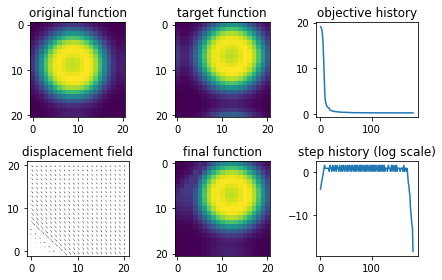

In [29]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(f)
ax[0, 0].set_title("original function")
ax[0, 1].imshow(g)
ax[0, 1].set_title("target function")
ax[1, 0].quiver(ux_GN, uy_GN)
ax[1, 0].set_title("displacement field")
ax[1, 1].imshow(interpol(f, ux_GN, uy_GN))
ax[1, 1].set_title("final function")
ax[0, 2].plot(CF_GN)
ax[0, 2].set_title("objective history")
ax[1, 2].plot(np.log(step_GN))
ax[1, 2].set_title("step history (log scale)")

plt.tight_layout()
plt.show()


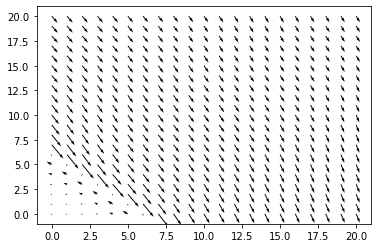

In [30]:
plt.quiver(ux_GN, uy_GN)
plt.show()


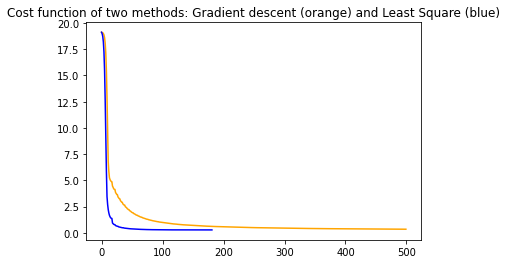

In [34]:
plt.plot(CF, color="orange")
plt.plot(CF_GN, color="blue")
plt.title(
    "Cost function of two methods: Gradient descent (orange) and Least Square (blue)"
)
plt.show()


D'après le graphe, on observe que la deuxième fonction de coût converge plus rapidement et s'arrête beaucoup plus tôt que la première.

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

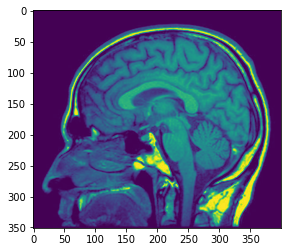

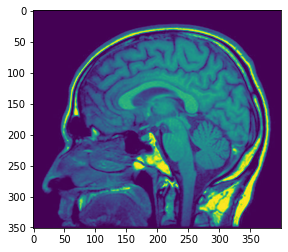

In [28]:
im1 = Image.open("IRM1.png")
im2 = Image.open("IRM2.png")
plt.imshow(plt.imread("IRM1.png"))
plt.show()
plt.imshow(plt.imread("IRM2.png"))
plt.show()


In [29]:
[n, m] = im1.size
sigma = 0.1
[X, Y] = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, m), indexing="xy")
Z = np.sqrt(X * X + Y * Y)
G = np.fft.fftshift(np.exp(-(X ** 2 + Y ** 2) / sigma ** 2))
f = np.real(np.fft.ifft2(np.fft.fft2(G) * np.fft.fft2(im1)))
g = np.real(np.fft.ifft2(np.fft.fft2(G) * np.fft.fft2(im2)))
f = f / np.max(f)
g = g / np.max(g)
